Se på null records

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def see_null(table):
    path = "../data/raw/MINDsmall_dev/"+table
    df = pd.read_csv(path, sep="\t")
    
    zeroes = df.isnull().sum() 
    counts = df.count()
    counts_df = pd.DataFrame({
        "cols" : df.columns,
        "zero" :zeroes.values,
        "actual" : counts.values,
    })

    print(counts_df)


In [3]:
see_null("behaviors.tsv")
print("---------------------------------")
see_null("news.tsv")



                                                cols  zero  actual
0                                                  1     0   73151
1                                             U80234     0   73151
2                             11/15/2019 12:37:50 PM     0   73151
3  N55189 N46039 N51741 N53234 N11276 N264 N40716...  2214   70937
4  N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...     0   73151
---------------------------------
                                                cols  zero  actual
0                                             N55528     0   42415
1                                          lifestyle     0   42415
2                                    lifestyleroyals     0   42415
3  The Brands Queen Elizabeth, Prince Charles, an...     0   42415
4  Shop the notebooks, jackets, and more that the...  2021   40394
5      https://assets.msn.com/labs/mind/AAGH0ET.html     0   42415
6  [{"Label": "Prince Philip, Duke of Edinburgh",...     2   42413
7                           

Ting some kan være interessant å se på
1. top 10 mest klikk og gjennomsnittlig klikk
2. kategori distribusjon
3. gjennomsnittlig klikk per time og for enkelte nyheter
4. hvor mange nye brukere (uten klikk)

In [4]:
# load and rename
behaviors_df = pd.read_csv('../data/raw/MINDsmall_dev/behaviors.tsv', sep="\t", names=["Impression ID", "User ID", "Time", "History", "Impressions"], header=None)
news_df = pd.read_csv('../data/raw/MINDsmall_dev/news.tsv', sep="\t", names=["News ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"], header=None)

print(news_df.columns)
print(behaviors_df.columns)



Index(['News ID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL',
       'Title Entities', 'Abstract Entities'],
      dtype='object')
Index(['Impression ID', 'User ID', 'Time', 'History', 'Impressions'], dtype='object')


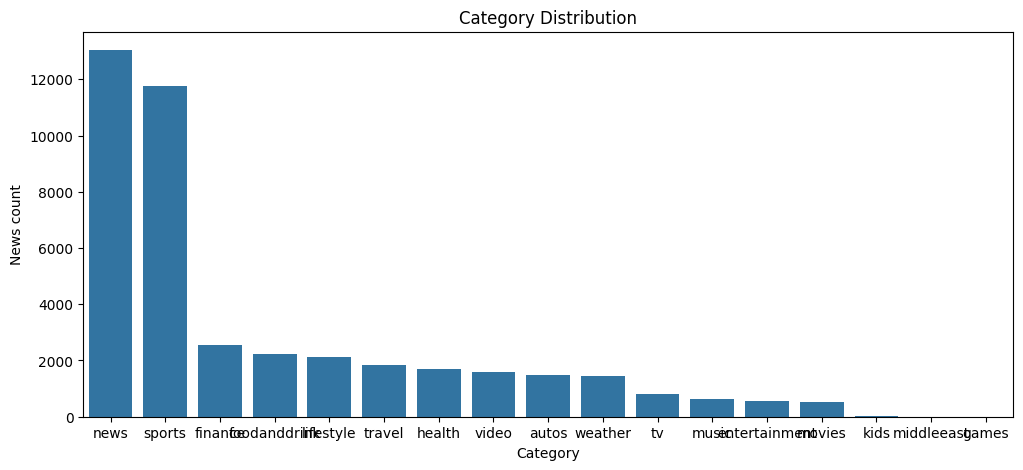

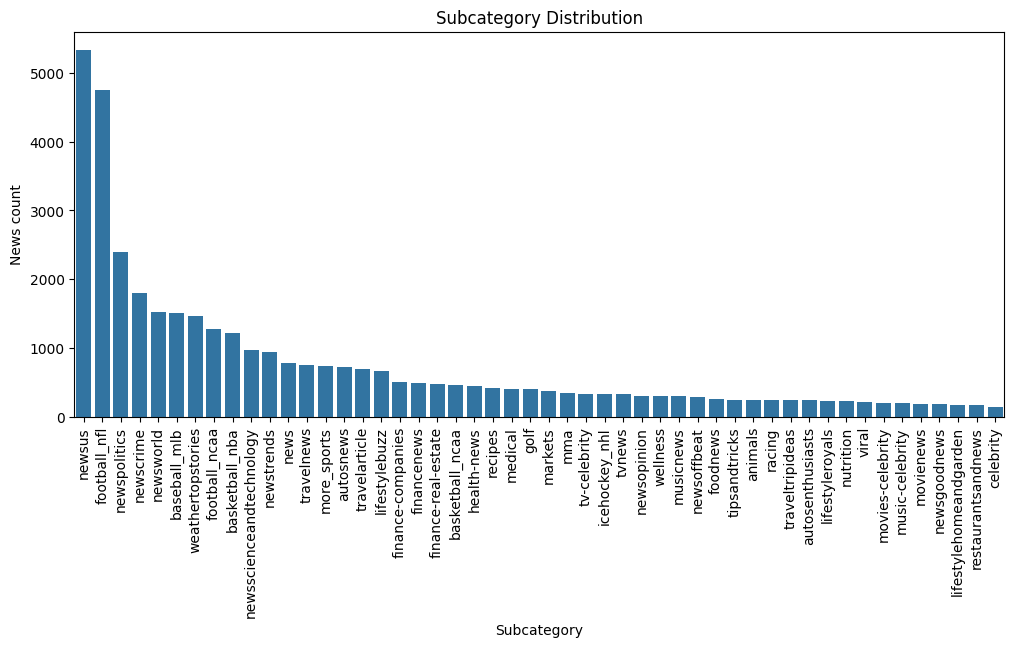

In [5]:
# columns er unnamed men de er index 1 og 2
subcat_counts= news_df['SubCategory'].value_counts()
category_counts= news_df['Category'].value_counts()

# Top 50 subcat fordi det var alfor mange
subcat_counts= subcat_counts.head(50)

plt.figure(figsize=(12, 5))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel("Category")
plt.ylabel("News count")

plt.title("Category Distribution")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=subcat_counts.index, y=subcat_counts.values)
plt.xlabel("Subcategory")
plt.ylabel("News count")
plt.xticks(rotation=90)
plt.title("Subcategory Distribution")
plt.show()

                 Time
0 2019-11-15 12:37:50
1 2019-11-15 08:25:46
2 2019-11-15 13:24:44
3 2019-11-15 07:15:13
4 2019-11-15 07:17:27
5 2019-11-15 08:23:05
6 2019-11-15 06:04:38
7 2019-11-15 09:45:18
8 2019-11-15 08:17:56
9 2019-11-15 05:36:43


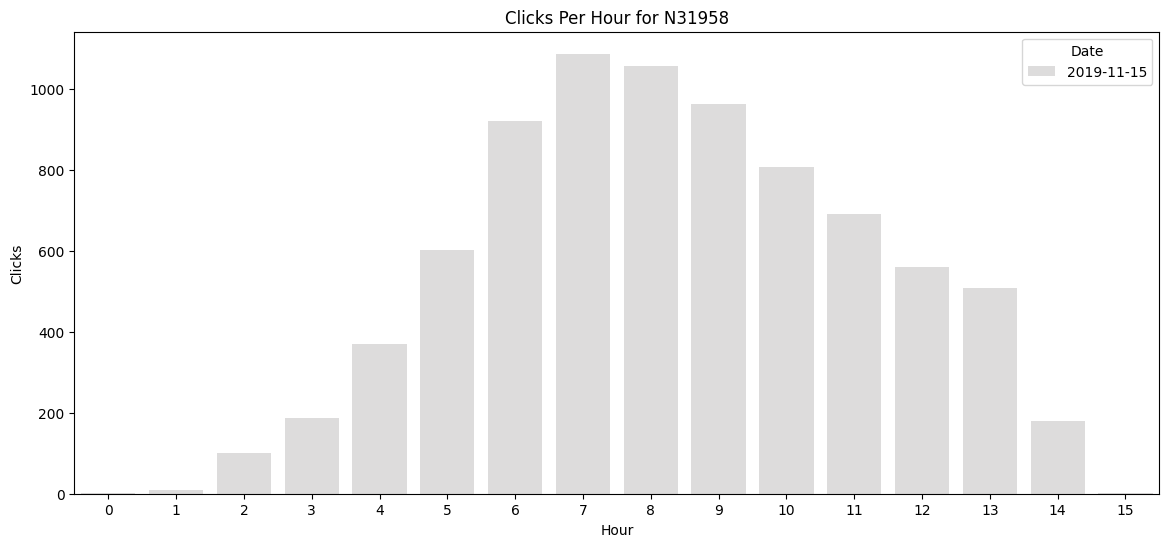

In [7]:
# convert time to datetime
behaviors_df["Time"] = pd.to_datetime(behaviors_df['Time'], format="%m/%d/%Y %I:%M:%S %p")

# når klikk skjedde
click_time = []
# her setter vi en tilfeldig news id for å se oppførsel
newsid = "N31958"

behaviors_df["Impressions"] = behaviors_df["Impressions"].fillna("").astype(str)
# sjekke historikken og se om nyhets artikkel ble klikket
for _, row in behaviors_df.iterrows():
    # get individiual impression
    for impression in row["Impressions"].split():
        news, click = impression.split('-')
        if news == newsid and int(click) == 1:  # If clicked
            click_time.append(row['Time'])

# prepare and gruop by day + hour
clicks_df = pd.DataFrame(click_time, columns=["Time"])
clicks_df["Time"] = pd.to_datetime(clicks_df["Time"])
print(clicks_df.head(10))

clicks_df["Date"] = clicks_df["Time"].dt.date  
clicks_df["Hour"] = clicks_df["Time"].dt.hour  
clicks_per_hour = clicks_df.groupby(["Date", "Hour"]).size().reset_index(name="Clicks")

#plot
plt.figure(figsize=(14, 6))
sns.barplot(data=clicks_per_hour, x="Hour", y="Clicks", hue="Date", palette="coolwarm")

plt.xlabel("Hour")
plt.ylabel("Clicks")
plt.title(f"Clicks Per Hour for {newsid}")

plt.show()




In [ ]:
## find users with no clicks, denne er buggy
active_users = set()
all_users = set()
for _, row in behaviors_df.iterrows():
    all_users.add(row['User ID'])
    for impression in row["Impressions"].split():
        news, click = impression.split('-')
        if int(click) == 1:  
            active_users.add(row['User ID'])

inactive_users = len(all_users) - len(active_users)
print(f"Number of inactive and active users: {inactive_users}, {len(active_users)}")


Number of inactive and active users: 0, 50000


In [ ]:
### top 10 most clicked articles
from collections import Counter
article_clicked = {}

for _, row in behaviors_df.iterrows():
    for impression in row["Impressions"].split():
        news, click = impression.split('-')
        if int(click) == 1:  
            article_clicked[news] = article_clicked.get(news, 0) + 1

top_10 =Counter(article_clicked).most_common(10)

for article, clicks in top_10:
    print(f"{article}: {clicks} clicks")


N31958: 8042 clicks
N36779: 4688 clicks
N5940: 4191 clicks
N20036: 3826 clicks
N23513: 2900 clicks
N30290: 2853 clicks
N58251: 2536 clicks
N24802: 2247 clicks
N5472: 2135 clicks
N53572: 1826 clicks
